# Jit Compilation with Jax

Google Jax supports just-in-time or 'jit' compilation of pure functions, which can make them an order of magnitude faster or more. Let's compare the speed of basic poppy and morphine with jit compilation to show the gains that can be made.

In [1]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

import morphine
from morphine.matrixDFT import minimal_dft
import poppy


In [2]:

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as u

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")


<ipython-input-2-626be4366fec>:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  phasemap.set_bad(color='k')


First we define some constants.

In [3]:
D = 2.
wavelen = 1e-6

NPIX = 128
FOV = 8.

Now let's define some functions - a non-jit version with morphine, a version with poppy, and a version with jit compilation of morphine. Jit compilation with Jax can often make functions an order of magnitude faster or more.

In [4]:
def morphine_min(wavel):
    empty = morphine.OpticalSystem(npix=NPIX)
    empty.add_pupil( morphine.CircularAperture(radius=1.),npix=NPIX)
    empty.add_detector( pixelscale=0.025, fov_arcsec=FOV )
    psf, instrument = empty.propagate_mono(wavel,retain_intermediates=False)
    return psf.intensity

jit_morphine = jit(morphine_min)

def poppy_basic(wavel):
    empty = poppy.OpticalSystem(npix=NPIX)
    empty.add_pupil( poppy.CircularAperture(radius=1.),npix=NPIX)
    empty.add_detector( pixelscale=0.025, fov_arcsec=FOV )
    psf, instrument = empty.propagate_mono(wavel)
    return psf[0].data

img_min = morphine_min(wavelen)
img_jit = jit_morphine(wavelen)
img_pop = poppy_basic(wavelen)

In [5]:
%%timeit
img_min = morphine_min(wavelen)

111 ms ± 29.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%%timeit
img_jit = jit_morphine(wavelen).block_until_ready()

10.4 ms ± 916 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%%timeit
img_pop = poppy_basic(wavelen)

28.9 ms ± 3.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So jit bought us a factor of three speedup over poppy straight out of the box!

Plot the images to show they are the same.

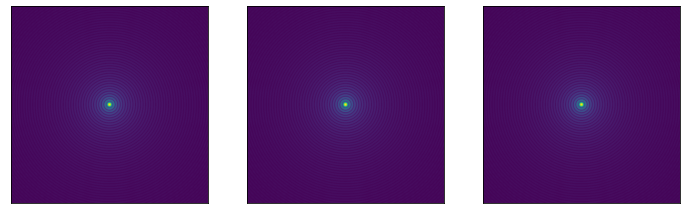

In [8]:
fig, axes = plt.subplots(1,3,figsize=(12.0,4.0))
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].imshow(img_min**0.25)
axes[1].imshow(img_jit**0.25)
axes[2].imshow(img_pop**0.25)
